# Classify movie reviews using Word Embeddings

In a previous notebook named `1_classify_movie_reviews.ipynb` I looked at classifying movie reviews into 'good' or 'bad', given the review text. I used one-hot encoding of the most common 10000 words to encode the text samples and reached accuracy of around 85% on the test set, using training on 15000 samples. In this notebook I will use "word encodings" to represent the text data of the same dataset: (1) learned from the actual IMDB dataset during training and (2) using pre-trained GloVe embeddings. Let's see how the performance of the two embeddings, one-hot and word embeddings, compares.

As usual we can start with importing the dataset, cut down to the most frequent 10000 words. 

In [2]:
from keras.datasets import imdb
from keras import preprocessing

The data is loaded as a list of integers (representing words), where x_train[i] is a given review of different length. We'll first cut the reviews to only the first 20 words. Shorter reviews will be padded with 0s up to 20 tokens. The following lines will turn a list of integers into a 2D integer tensor of shape (samples, max_review_length).

In [105]:
MAX_REVIEW_LENGTH = 100  # cutoff of review in word count
MAX_FEATURES = 10000  # number of most frequently words to be used

In [61]:
def prepare_data():
    """
    Loads imdb data and splits it into train / val / test sets.
    """
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    print("Number of training samples:", len(x_train))

    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_REVIEW_LENGTH)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_REVIEW_LENGTH)

    # Split a part of the training dataset for validation
    x_val = x_train[:10000]
    y_val = y_train[:10000]
    x_train = x_train[10000:]
    y_train = y_train[10000:]

    print("x_train.shape:", x_train.shape)
    print("x_val.shape:", x_val.shape)
    print("x_test.shape:", x_test.shape)
    
    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))

In [106]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()

Number of training samples: 25000
x_train.shape: (15000, 100)
x_val.shape: (10000, 100)
x_test.shape: (25000, 100)


Note that we have to truncate the reviews to a fixed size so they can be inserted in the Embedding layer.

## Learning embeddings during training

Keras makes it simple to learn word embeddings during training of the classification model. This seams a bit weird, since we'll be using uncompletely trained embeddings to train a classification model. It feels more natural to first train the embeddings and then use them in the classification model training, otherwise we'd be using inaccurate embeddings. Anyway, this needs to be looked at how exactly is implemented inside Keras, as it would be interesting to see how the developers have solved this problem. For now, I'll use the Embedding layer of Keras to do embedding training as listed in the documentation. The following lines create and train a classification model, while also calculating the word embeddings.

In [109]:
def train_model_learn_embeddings(epochs=10, batch_size=32):
    """
    Creates a model and trains both model's weights and word embeddings
    """

    from keras.models import Sequential
    from keras.layers import Flatten, Dense, Embedding

    model = Sequential()
    model.add(Embedding(15000, 8, input_length=MAX_REVIEW_LENGTH))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_val, y_val), 
                        verbose=False)
    return model, history

In [110]:
model, history = train_model_learn_embeddings(epochs=10, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 8)            120000    
_________________________________________________________________
flatten_17 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                25632     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
def plot_history(history, review_length = 100):
    """
    Plots the history of a model training - its loss and accuracy.
    """
    
    import matplotlib.pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy [review length: %d]' % review_length)
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss [review length: %d]' % review_length)
    plt.legend()
    plt.show()

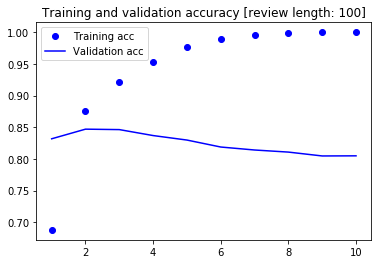

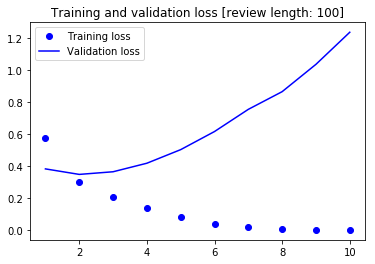

In [111]:
plot_history(history, review_length=100)

In [118]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss: %.3f, test accuracy: %.3f." % (test_loss, test_acc))

25000/25000 [==============================] - 1s 42us/step
Test loss: 1.219, test accuracy: 0.797.


So in epoch 2 our model managed to reach the maximum accuracy of around 85%. Even if the reviews were truncated to 100 words we almost reached the performance of the one-hot encoding case of around 87%. Let's try to use even longer reviews.

Number of training samples: 25000
x_train.shape: (15000, 150)
x_val.shape: (10000, 150)
x_test.shape: (25000, 150)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 150, 8)            120000    
_________________________________________________________________
flatten_19 (Flatten)         (None, 1200)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                38432     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 158,465
Trainable params: 158,465
Non-trainable params: 0
_________________________________________________________________
None


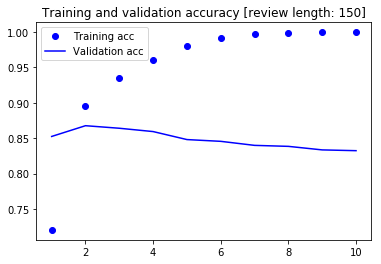

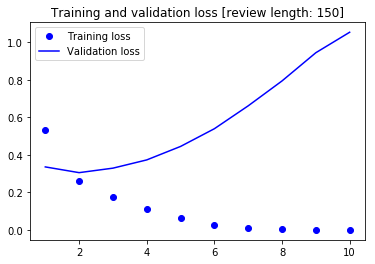

25000/25000 [==============================] - 2s 62us/step
Test loss: 1.091, test accuracy: 0.823.


In [120]:
MAX_REVIEW_LENGTH = 150
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()
model, history = train_model_learn_embeddings(epochs=10, batch_size=32)
plot_history(history, review_length=150)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss: %.3f, test accuracy: %.3f." % (test_loss, test_acc))

Ok with 150 words per review the performance of the one-hot case is precicely matched. But what if we use some big review length, so that big part of the sequences will be padded with zeros? Will the performance drop?

Number of training samples: 25000
x_train.shape: (15000, 500)
x_val.shape: (10000, 500)
x_test.shape: (25000, 500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 500, 8)            120000    
_________________________________________________________________
flatten_20 (Flatten)         (None, 4000)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                128032    
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 248,065
Trainable params: 248,065
Non-trainable params: 0
_________________________________________________________________
None


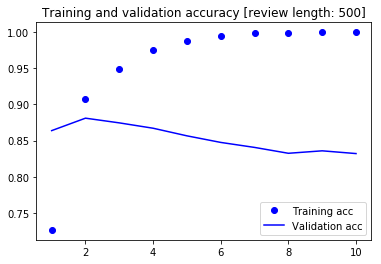

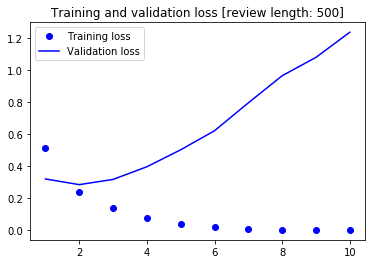

25000/25000 [==============================] - 1s 56us/step
Test loss: 1.236, test accuracy: 0.832.


In [121]:
# There are rarely reviews of more than 500 words. Usually around 150
MAX_REVIEW_LENGTH = 500
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()
model, history = train_model_learn_embeddings(epochs=10, batch_size=32)
plot_history(history, review_length=500)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss: %.3f, test accuracy: %.3f." % (test_loss, test_acc))

Well padding big part of the sequences with zeros seems to not have any negative effect. Contrary, we have used almost all of the information in the reviews (there might be some review with more than 500 words) and therefore reached top performance with this approach of around 88%. Note that the test performance of the above models refers to the model at its 10th epoch of training, not the optimal one. This is why test results show a bit lower performance compared to the validation ones.

**Conclusion**: training the word embeddings on the IMDB dataset and using them in a standard feed-forward neural network has pretty much the same performance as using the word one-hot encodings. Still the advantage of embeddings is that we use compressed information, 100 to 500 seqence length compared with the 10000 vector length in one-hot, and still reached the same performance.

In the following part, let's see if we can do better by using pre-trained embeddings - the GloVe embeddings created by Stanford University, which are calculated on much larger text datasets.

## Using pretrained word embeddings

We can now use the GloVe embeddings, which were previously downloaded from this [link](https://nlp.stanford.edu/projects/glove/). We'll use the GloVe embeddings using 100 dimensions ie., each word (of the 400000 ones) will be encoded in a 100D vector. Let's first process the text data and store it into a Python dictionary with key equal to the word, and value equal to the weights.

In [64]:
import os
import numpy as np

glove_dir = '/Users/Misko/PycharmProjects/Playfield/data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now we need to construct an embedding_matrix of shape (MAX_FEATURES, 100), where 100 is the embedding dimension given in the downloaded GloVe embeddings. To contstruct it, we need to find the top MAX_FEATURES words and append their 100D vectors into a matrix. 

In [91]:
# Re-initialise review length and no. of words to use
MAX_REVIEW_LENGTH =  150
MAX_FEATURES = 10000
EMBEDDING_DIM = 100  # as in the downloaded data

# Get word-index tuples for the dataset
word_index = imdb.get_word_index()

# Sort the word_index so later we can get the first MAX_FEATURES words
sorted_word_index = sorted(word_dict.items(), key=lambda x: x[1])

# Print out the most frequent 10 words to check if things are done right
most_frequent_10_words = [word[0] for word in sorted_word_index][:10]
print("Most frequent 10 words:", most_frequent_10_words)

# Create the embedding matrix
embedding_matrix = np.zeros((MAX_FEATURES, EMBEDDING_DIM))
index = 0
for word, _ in sorted_word_index[:MAX_FEATURES]:
    embedding_vector = embeddings_index.get(word)
    embedding_matrix[index] = embedding_vector
    index += 1

Most frequent 10 words: ['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']


In [123]:
def train_model_pretrained_embeddings(epochs=10, batch_size=32):

    from keras.models import Sequential
    from keras.layers import Embedding, Flatten, Dense

    # Create a model same as above
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    
    # Freeze word embeddings
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=False)
    
    # Save model to file
    model.save_weights('pre_trained_glove_model.h5')
    
    return model, history

Number of training samples: 25000
x_train.shape: (15000, 500)
x_val.shape: (10000, 500)
x_test.shape: (25000, 500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
flatten_21 (Flatten)         (None, 50000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1600032   
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 2,600,065
Trainable params: 2,600,065
Non-trainable params: 0
_________________________________________________________________
None


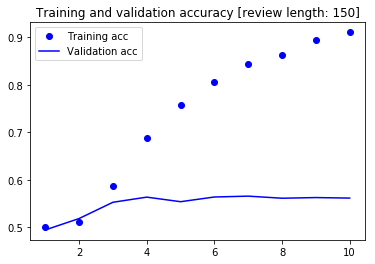

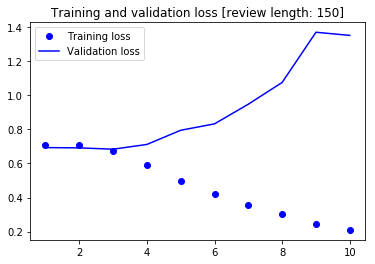

25000/25000 [==============================] - 6s 223us/step
Test loss: 1.319, test accuracy: 0.564.


In [124]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()
model, history = train_model_pretrained_embeddings(epochs=10, batch_size=32)
plot_history(history, review_length=150)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss: %.3f, test accuracy: %.3f." % (test_loss, test_acc))

Although you might have expected that the pre-trained embeddings would give better results, it's actually the opposite. So probably word embeddings learned on the specific task are a better option. Let's try with more words included in a review.. it might be able to improve results a little bit.

Number of training samples: 25000
x_train.shape: (15000, 500)
x_val.shape: (10000, 500)
x_test.shape: (25000, 500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
flatten_22 (Flatten)         (None, 50000)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1600032   
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 33        
Total params: 2,600,065
Trainable params: 2,600,065
Non-trainable params: 0
_________________________________________________________________
None


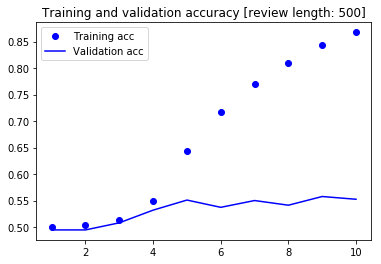

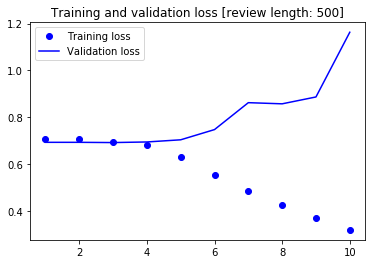

In [125]:
MAX_REVIEW_LENGTH = 500
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()
model, history = train_model_pretrained_embeddings(epochs=10, batch_size=32)
plot_history(history, review_length=500)

Again, pre-trained word embeddings didn't work well on the movie reviews classification task. This could probably be because the GloVe embeddings were computed on data collected from Wikipedia (among others), while the movie reviews are written in a more free way, using slang and everyday speech.

All in all, this notebook introduced word embeddings, both trained from scratch (self-encoded) and pre-trained, in a task of predicting movie reviews as 'good' or 'bad'. Results were compared with another notebook, named `1_classify_movie_reviews.ipynb`, where tokens in movie reviews are encoded using one-hot encoding. Both approaches used a standard feed-forward neural network to do the classification. The model performance is similar for both one-hot and self-encoded approaches, topping to around 87% accuracy. Using the pre-trained word embeddings by Stanford, showed worse results.

In the following notebooks, I'll be looking at the problem again, tackling it with recurrent neural networks (RNNs), which are the state of the art tools for machine learning on sequence data. Since they would be able to capture the meaning in between words in the sentences, I expect to get a substantial improvement in performance. 

## References
- "Deep Learning with Python" book by Francois Chollet